In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm
import h5py

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(28)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.148.1.19:35728 Dashboard: http://10.148.1.19:8787/status,Cluster Workers: 56 Cores: 224 Memory: 2800.00 GB


---


# 1. Drifter data files

In [8]:
# The prcessed dataset includes both the GPS- and Argo-tracked surface drifters.
# 2-month blocks with overlapping by 50%

data_dir = '/home1/datawork/xyu/Drifters/'

drifter_dataset = h5py.File(data_dir+'Drifter_dataset_processed.mat','r') 
list(drifter_dataset.items())

# mlat2: mean latitude over 60 days,     126303*1
# mlon2: mean longitude over 60 days,    126303*1

# qd: drogued drifters,                  126303*1
# qmed200: median water depth > 200 m,   126303*1
# qu: undrogued drifters,                126303*1

# uv2: (u, v),                           126303*1440

[('mlat2', <HDF5 dataset "mlat2": shape (126303, 1), type "<f8">),
 ('mlon2', <HDF5 dataset "mlon2": shape (126303, 1), type "<f8">),
 ('qd', <HDF5 dataset "qd": shape (126303, 1), type "|u1">),
 ('qmed200', <HDF5 dataset "qmed200": shape (126303, 1), type "|u1">),
 ('qu', <HDF5 dataset "qu": shape (126303, 1), type "|u1">),
 ('uv2', <HDF5 dataset "uv2": shape (126303, 1440), type "|V16">)]

In [6]:
# turn mean-lat into xarray_DataArray
lat2 = drifter_dataset['mlat2']
lat2 = np.array(lat2)
lat = xr.DataArray(lat2, dims=['lat', 'none'])
lat = xr.DataArray.squeeze(lat, dim='none')
lat = np.real(lat).rename('lat')
lat

<xarray.DataArray 'lat' (lat: 126303)>
array([ 39.51519 ,  39.682915,  40.437454, ..., -60.776903,  32.794351,
        27.131247])
Dimensions without coordinates: lat

In [7]:
# turn drogued_information into xarray_DataArray
qd = drifter_dataset['qd']
qd = np.array(qd)
qd = xr.DataArray(qd, dims=['qd', 'none'])
qd = xr.DataArray.squeeze(qd, dim='none')
qd = np.real(qd).rename('qd')
qd

<xarray.DataArray 'qd' (qd: 126303)>
array([0, 0, 0, ..., 1, 1, 1], dtype=uint8)
Dimensions without coordinates: qd

In [8]:
# (u,v) --> u+iv
uv = drifter_dataset['uv2'].value.view(np.double).reshape((126303, 1440, 2))
uv_drifters = uv[:,:,0] + 1j*uv[:,:,1]
uv_drifters.shape  # result is (10, 10, 10)
uv_drifters

array([[-0.2105+0.2479j, -0.1988+0.2534j, -0.1829+0.2546j, ...,
        -0.1973-0.0078j, -0.1291-0.0124j, -0.1243-0.0125j],
       [ 0.3416-0.1573j, -0.2791-0.148j , -0.2816-0.1608j, ...,
         0.5124+0.5065j,  0.2544+0.279j ,  0.2522+0.3207j],
       [-0.0447-0.0348j, -0.0473-0.0349j, -0.0483-0.0346j, ...,
        -0.1598-0.0051j, -0.1594-0.0067j, -0.1592-0.0112j],
       ...,
       [-0.133 -0.0436j, -0.1051-0.0644j, -0.078 -0.0867j, ...,
        -0.156 +0.1021j, -0.1438+0.0432j, -0.1106-0.006j ],
       [ 0.2182+0.1123j,  0.3067+0.0383j,  0.2961-0.0329j, ...,
        -0.0586+0.0723j, -0.0434+0.0244j, -0.0587+0.0083j],
       [ 0.1311+0.2634j,  0.1947+0.266j ,  0.1697+0.1318j, ...,
        -0.3065-0.0724j, -0.2364-0.0343j, -0.2099-0.0333j]])

In [9]:
# Drifter Dataset (u+iv,lat,qd,time)
ds = xr.Dataset({'uv_drifters': (['lat', 'time'], uv_drifters)},
                 coords={'lat': (['lat'], lat),
                         'time':(['time'], np.arange(1440)*3600),
                         'qd':(['lat'], qd)})
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:      (lat: 126303, time: 1440)
Coordinates:
  * lat          (lat) float64 39.52 39.68 40.44 32.82 33.22 33.98 35.36 ...
  * time         (time) int64 0 3600 7200 10800 14400 18000 21600 25200 ...
    qd           (lat) uint8 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 ...
Data variables:
    uv_drifters  (lat, time) complex128 (-0.2105+0.2479j) (-0.1988+0.2534j) ...

 data size: 2.9 GB


In [10]:
file_E = data_dir+'mit_spec/Drifter_processeddata.zarr'
%time ds.to_zarr(file_E, mode='w')  

CPU times: user 5.04 s, sys: 668 ms, total: 5.71 s
Wall time: 31.9 s


_________
# 2. Rotary spectra of Drifter uv

In [27]:
data_dir = '/home1/datawork/xyu/Drifters/'
ds = xr.open_zarr(data_dir+'mit_spec/Drifter_processeddata.zarr').chunk({'time': 1440, 'lat': 1}) 
ds

<xarray.Dataset>
Dimensions:      (lat: 126303, time: 1440)
Coordinates:
  * lat          (lat) float64 39.52 39.68 40.44 32.82 33.22 33.98 35.36 ...
    qd           (lat) uint8 dask.array<shape=(126303,), chunksize=(1,)>
  * time         (time) int64 0 3600 7200 10800 14400 18000 21600 25200 ...
Data variables:
    uv_drifters  (lat, time) complex128 dask.array<shape=(126303, 1440), chunksize=(1, 1440)>

In [6]:
uv_fft_complex = xrft.dft(ds.uv_drifters.where(ds.qd>0).fillna(0.), dim=['time'], shift=False, detrend=False, window=False, chunks_to_segments=False)

E_uv_blocks = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/1440*3600
E_uv_blocks = np.real(E_uv_blocks).rename('E_uv_blocks')
E_uv_blocks = E_uv_blocks.assign_coords(freq_cpd=E_uv_blocks.freq_time * 86400.) 
E_uv_zonmean = (E_uv_blocks.groupby_bins(E_uv_blocks.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat']))

E_drifter_raw = E_uv_zonmean#.load()
E_drifter_raw = np.real(E_drifter_raw).rename('E_drifter_raw')
file_E = data_dir+'mit_spec/E_drifter_raw.zarr'
%time E_drifter_raw.to_dataset().to_zarr(file_E, mode='w')  

CPU times: user 6.31 s, sys: 296 ms, total: 6.6 s
Wall time: 19 s


In [7]:
uv_fft_complex = xrft.dft(ds.uv_drifters.where(ds.qd>0).fillna(0.), dim=['time'], shift=False, detrend=False, window=True, chunks_to_segments=False)

E_uv_blocks = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/1440*3600
E_uv_blocks = np.real(E_uv_blocks).rename('E_uv_blocks')
E_uv_blocks = E_uv_blocks.assign_coords(freq_cpd=E_uv_blocks.freq_time * 86400.) 
E_uv_zonmean = (E_uv_blocks.groupby_bins(E_uv_blocks.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat']))

E_drifter_window = E_uv_zonmean#.load()
E_drifter_window = np.real(E_drifter_window).rename('E_drifter_window')
file_E = data_dir+'mit_spec/E_drifter_window.zarr'
%time E_drifter_window.to_dataset().to_zarr(file_E, mode='w')  

CPU times: user 4.39 s, sys: 252 ms, total: 4.64 s
Wall time: 8.49 s


In [8]:
uv_fft_complex = xrft.dft(ds.uv_drifters.where(ds.qd>0).fillna(0.), dim=['time'], shift=False, detrend='constant', window=False, chunks_to_segments=False)

E_uv_blocks = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/1440*3600
E_uv_blocks = np.real(E_uv_blocks).rename('E_uv_blocks')
E_uv_blocks = E_uv_blocks.assign_coords(freq_cpd=E_uv_blocks.freq_time * 86400.) 
E_uv_zonmean = (E_uv_blocks.groupby_bins(E_uv_blocks.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat']))

E_drifter_constant = E_uv_zonmean#.load()
E_drifter_constant = np.real(E_drifter_constant).rename('E_drifter_constant')
file_E = data_dir+'mit_spec/E_drifter_constant.zarr'
%time E_drifter_constant.to_dataset().to_zarr(file_E, mode='w')  

CPU times: user 5.54 s, sys: 336 ms, total: 5.88 s
Wall time: 11.8 s


In [10]:
uv_fft_complex = xrft.dft(ds.uv_drifters.where(ds.qd>0).fillna(0.), dim=['time'], shift=False, detrend='linear', window=False, chunks_to_segments=False)

E_uv_blocks = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/1440*3600
E_uv_blocks = np.real(E_uv_blocks).rename('E_uv_blocks')
E_uv_blocks = E_uv_blocks.assign_coords(freq_cpd=E_uv_blocks.freq_time * 86400.) 
E_uv_zonmean = (E_uv_blocks.groupby_bins(E_uv_blocks.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat']))

E_drifter_linear = E_uv_zonmean#.load()
E_drifter_linear = np.real(E_drifter_linear).rename('E_drifter_linear')
file_E = data_dir+'mit_spec/E_drifter_linear.zarr'
%time E_drifter_linear.to_dataset().to_zarr(file_E, mode='w')  

CPU times: user 4.89 s, sys: 180 ms, total: 5.07 s
Wall time: 203 ms


In [10]:
uv_fft_complex = xrft.dft(ds.uv_drifters.where(ds.qd>0).fillna(0.), dim=['time'], shift=False, detrend='constant', window=True, chunks_to_segments=False)

E_uv_blocks = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/1440*3600
E_uv_blocks = np.real(E_uv_blocks).rename('E_uv_blocks')
E_uv_blocks = E_uv_blocks.assign_coords(freq_cpd=E_uv_blocks.freq_time * 86400.) 
E_uv_zonmean = (E_uv_blocks.groupby_bins(E_uv_blocks.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat']))

E_drifter_constant_window = E_uv_zonmean#.load()
E_drifter_constant_window = np.real(E_drifter_constant_window).rename('E_drifter_constant_window')
file_E = data_dir+'mit_spec/E_drifter_constant_window.zarr'
%time E_drifter_constant_window.to_dataset().to_zarr(file_E, mode='w')  

CPU times: user 7.68 s, sys: 316 ms, total: 8 s
Wall time: 15.9 s


In [11]:
uv_fft_complex = xrft.dft(ds.uv_drifters.where(ds.qd>0).fillna(0.), dim=['time'], shift=False, detrend='linear', window=True, chunks_to_segments=False)

E_uv_blocks = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/1440*3600
E_uv_blocks = np.real(E_uv_blocks).rename('E_uv_blocks')
E_uv_blocks = E_uv_blocks.assign_coords(freq_cpd=E_uv_blocks.freq_time * 86400.) 
E_uv_zonmean = (E_uv_blocks.groupby_bins(E_uv_blocks.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat']))

E_drifter_linear_window = E_uv_zonmean#.load()
E_drifter_linear_window = np.real(E_drifter_linear_window).rename('E_drifter_linear_window')
file_E = data_dir+'mit_spec/E_drifter_linear_window.zarr'
%time E_drifter_linear_window.to_dataset().to_zarr(file_E, mode='w')  

CPU times: user 520 ms, sys: 20 ms, total: 540 ms
Wall time: 19.4 ms


_________
# 3. Load dataset

In [9]:
ds_raw = xr.open_zarr(data_dir+'mit_spec/E_drifter_raw.zarr').chunk({'freq_time': 1440, 'lat_bins': 1}) 
ds_window = xr.open_zarr(data_dir+'mit_spec/E_drifter_window.zarr').chunk({'freq_time': 1440, 'lat_bins': 1}) 
ds_constant = xr.open_zarr(data_dir+'mit_spec/E_drifter_constant.zarr').chunk({'freq_time': 1440, 'lat_bins': 1}) 
ds_linear = xr.open_zarr(data_dir+'mit_spec/E_drifter_linear.zarr').chunk({'freq_time': 1440, 'lat_bins': 1}) 
ds_constant_window = xr.open_zarr(data_dir+'mit_spec/E_drifter_constant_window.zarr').chunk({'freq_time': 1440, 'lat_bins': 1}) 
ds_linear_window = xr.open_zarr(data_dir+'mit_spec/E_drifter_linear_window.zarr').chunk({'freq_time': 1440, 'lat_bins': 1}) 

In [10]:
E_drifter_raw = ds_raw.E_drifter_raw
E_drifter_window = ds_window.E_drifter_window
E_drifter_constant = ds_constant.E_drifter_constant
E_drifter_linear = ds_linear.E_drifter_linear
E_drifter_constant_window = ds_constant_window.E_drifter_constant_window
E_drifter_linear_window = ds_linear_window.E_drifter_linear_window 

In [11]:
df=ds_raw.freq_time[1]-ds_raw.freq_time[0]
print(df)

<xarray.DataArray 'freq_time' ()>
array(1.929012e-07)
Coordinates:
    freq_time_spacing  float64 1.929e-07


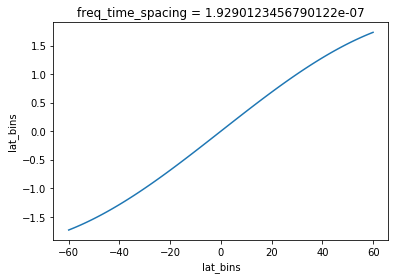

In [12]:
# Inertial frequency
f_drifter = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_drifter_raw.lat_bins))
f_cpd_drifter = f_drifter*86400/2./np.pi
f_cpd_drifter.plot()

Text(0.5,1,'Drifters')

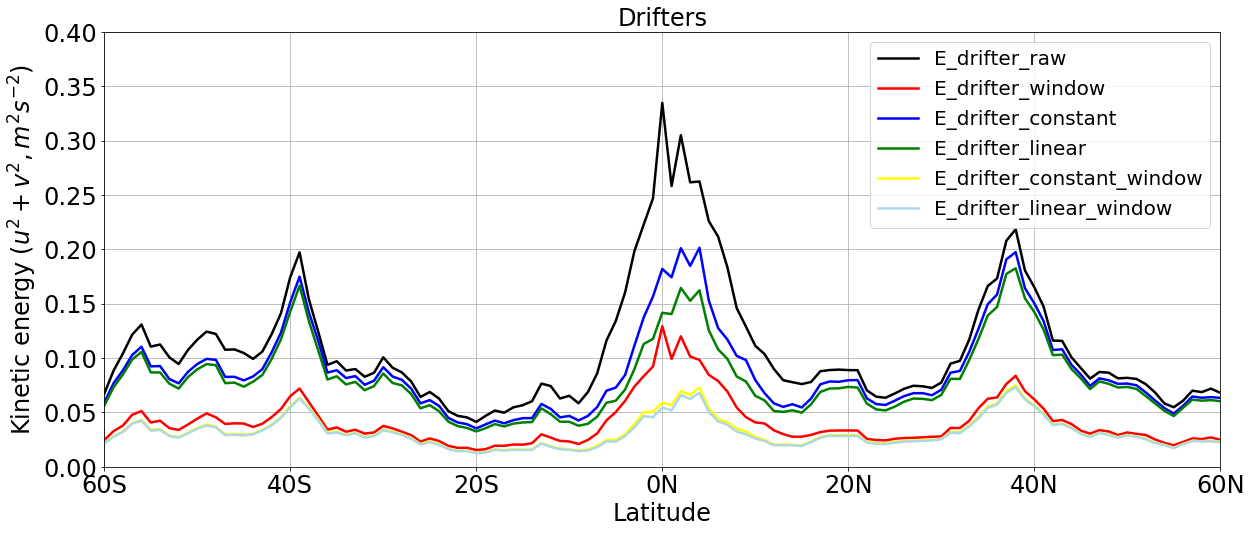

In [22]:
# linearly detrended

fig, ax = plt.subplots(figsize=(20,8))

labels = ['E_drifter_raw', 'E_drifter_window','E_drifter_constant', 'E_drifter_linear', 'E_drifter_constant_window','E_drifter_linear_window']

(E_drifter_raw*df).sum(dim='freq_time').plot(color='black', label=labels[0], linewidth=2.5) # total energy
(E_drifter_window*df).sum(dim='freq_time').plot(color='red', label=labels[1], linewidth=2.5) # total energy
(E_drifter_constant*df).sum(dim='freq_time').plot(color='blue', label=labels[2], linewidth=2.5) # total energy
(E_drifter_linear*df).sum(dim='freq_time').plot(color='green', label=labels[3], linewidth=2.5) # total energy
(E_drifter_constant_window*df).sum(dim='freq_time').plot(color='yellow', label=labels[4], linewidth=2.5) # total energy
(E_drifter_linear_window*df).sum(dim='freq_time').plot(color='lightblue', label=labels[5], linewidth=2.5) # total energy

ax.legend(prop={'size': 20}); 
ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.4])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

ax.set_title('Drifters',fontsize=24)

Text(0.5,1,'Drifters')

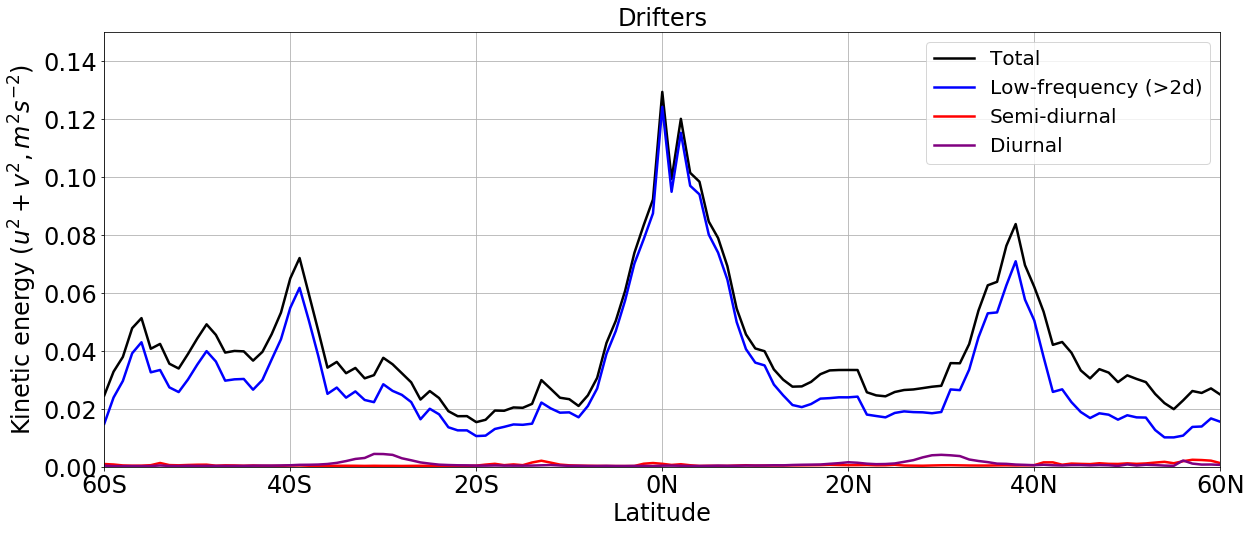

In [26]:
E_drifter = E_drifter_window

fig, ax = plt.subplots(figsize=(20,8))

labels = ['Total', 'Low-frequency (>2d)','Semi-diurnal', 'Diurnal', 'Near-inertial']

(E_drifter*df).sum(dim='freq_time').plot(color='black', label=labels[0], linewidth=2.5) # total energy
(E_drifter.where((abs(E_drifter.freq_cpd)>=0) & (abs(E_drifter.freq_cpd)<0.5) , other=0.)*df).sum(dim='freq_time').plot(color='blue', label=labels[1], linewidth=2.5)   # energy at low frequencies (> 5 days) 
(E_drifter.where((abs(E_drifter.freq_cpd)>1.9) & (abs(E_drifter.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time').plot(color='red', label=labels[2], linewidth=2.5) # energy around semi-diurnal frequencies
(E_drifter.where((abs(E_drifter.freq_cpd)>0.9) & (abs(E_drifter.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time').plot(color='purple', label=labels[3], linewidth=2.5) # energy around diurnal frequencies

ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.15])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

ax.set_title('Drifters',fontsize=24)

Text(0.5,1,'Drifters')

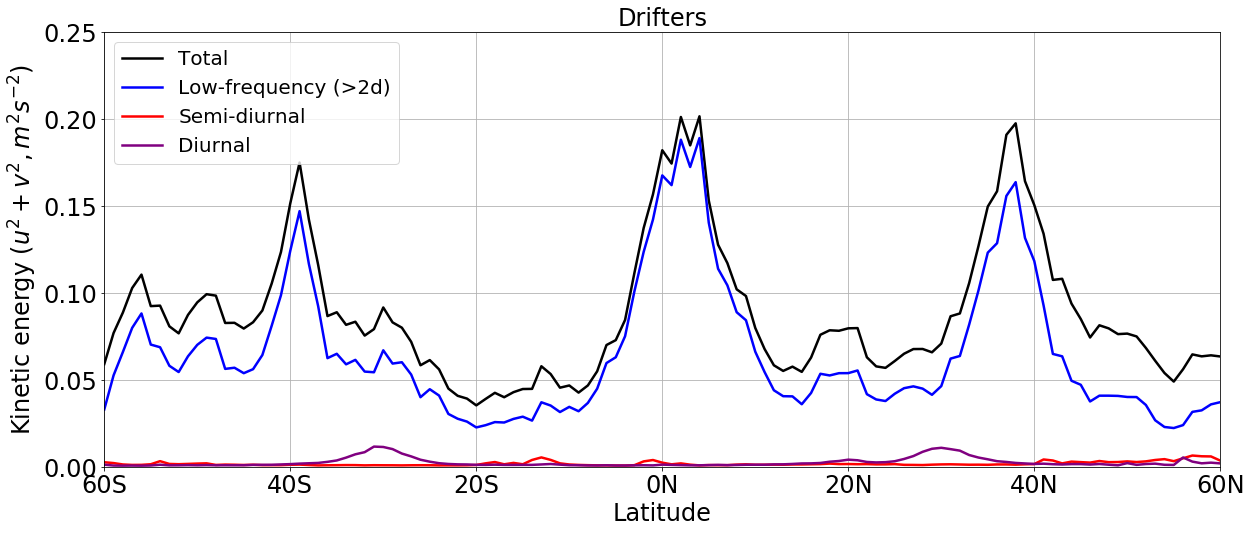

In [15]:
E_drifter = E_drifter_constant

fig, ax = plt.subplots(figsize=(20,8))

labels = ['Total', 'Low-frequency (>2d)','Semi-diurnal', 'Diurnal', 'Near-inertial']

(E_drifter*df).sum(dim='freq_time').plot(color='black', label=labels[0], linewidth=2.5) # total energy
(E_drifter.where((abs(E_drifter.freq_cpd)>=0) & (abs(E_drifter.freq_cpd)<0.5) , other=0.)*df).sum(dim='freq_time').plot(color='blue', label=labels[1], linewidth=2.5)   # energy at low frequencies (> 5 days) 
(E_drifter.where((abs(E_drifter.freq_cpd)>1.9) & (abs(E_drifter.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time').plot(color='red', label=labels[2], linewidth=2.5) # energy around semi-diurnal frequencies
(E_drifter.where((abs(E_drifter.freq_cpd)>0.9) & (abs(E_drifter.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time').plot(color='purple', label=labels[3], linewidth=2.5) # energy around diurnal frequencies

ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.25])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

ax.set_title('Drifters',fontsize=24)

Text(0.5,1,'Drifters')

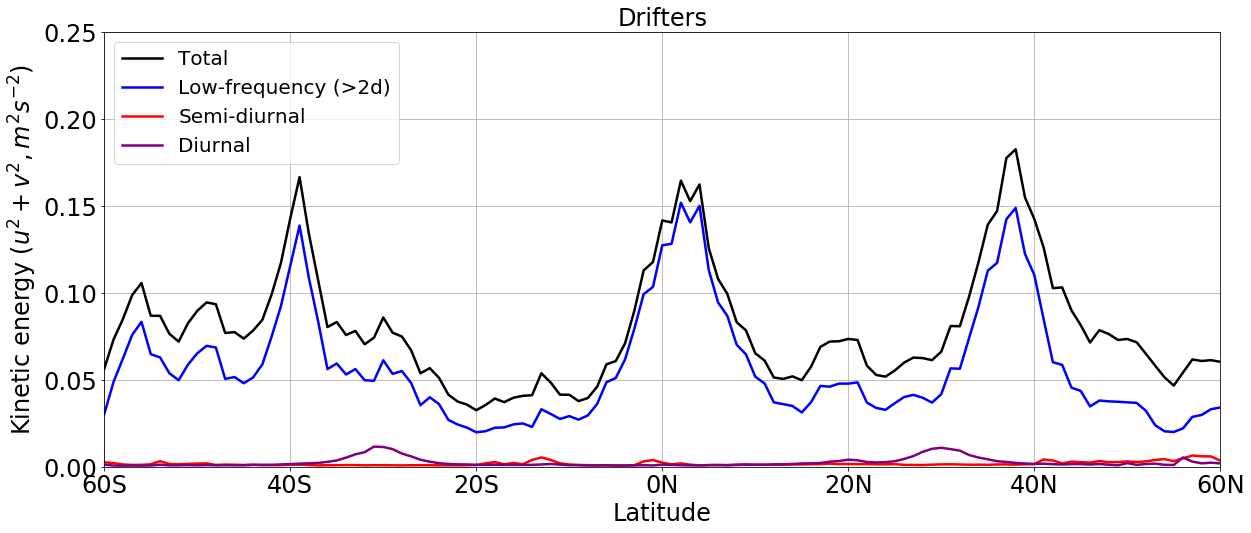

In [16]:
E_drifter = E_drifter_linear

fig, ax = plt.subplots(figsize=(20,8))

labels = ['Total', 'Low-frequency (>2d)','Semi-diurnal', 'Diurnal', 'Near-inertial']

(E_drifter*df).sum(dim='freq_time').plot(color='black', label=labels[0], linewidth=2.5) # total energy
(E_drifter.where((abs(E_drifter.freq_cpd)>=0) & (abs(E_drifter.freq_cpd)<0.5) , other=0.)*df).sum(dim='freq_time').plot(color='blue', label=labels[1], linewidth=2.5)   # energy at low frequencies (> 5 days) 
(E_drifter.where((abs(E_drifter.freq_cpd)>1.9) & (abs(E_drifter.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time').plot(color='red', label=labels[2], linewidth=2.5) # energy around semi-diurnal frequencies
(E_drifter.where((abs(E_drifter.freq_cpd)>0.9) & (abs(E_drifter.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time').plot(color='purple', label=labels[3], linewidth=2.5) # energy around diurnal frequencies

ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.25])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

ax.set_title('Drifters',fontsize=24)

Text(0.5,1,'Drifters (Semi-diurnal)')

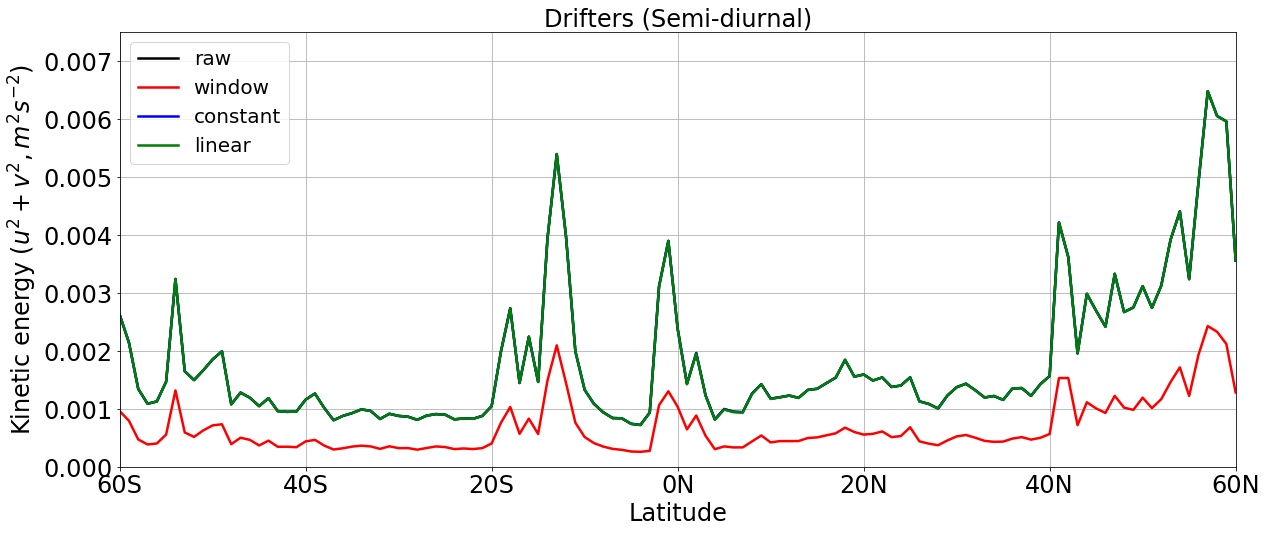

In [29]:
# semi-diurnal 

fig, ax = plt.subplots(figsize=(20,8))

labels = ['raw', 'window','constant', 'linear']

(E_drifter_raw.where((abs(E_drifter_raw.freq_cpd)>1.9) & (abs(E_drifter_raw.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time').plot(color='black', label=labels[0], linewidth=2.5) # energy around semi-diurnal frequencies
(E_drifter_window.where((abs(E_drifter_window.freq_cpd)>1.9) & (abs(E_drifter_window.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time').plot(color='red', label=labels[1], linewidth=2.5) # energy around semi-diurnal frequencies
(E_drifter_constant.where((abs(E_drifter_constant.freq_cpd)>1.9) & (abs(E_drifter_constant.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time').plot(color='blue', label=labels[2], linewidth=2.5) # energy around semi-diurnal frequencies
(E_drifter_linear.where((abs(E_drifter_linear.freq_cpd)>1.9) & (abs(E_drifter_linear.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time').plot(color='green', label=labels[3], linewidth=2.5) # energy around semi-diurnal frequencies

ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.0075])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

ax.set_title('Drifters (Semi-diurnal)',fontsize=24)

Text(0.5,1,'Drifters (Diurnal)')

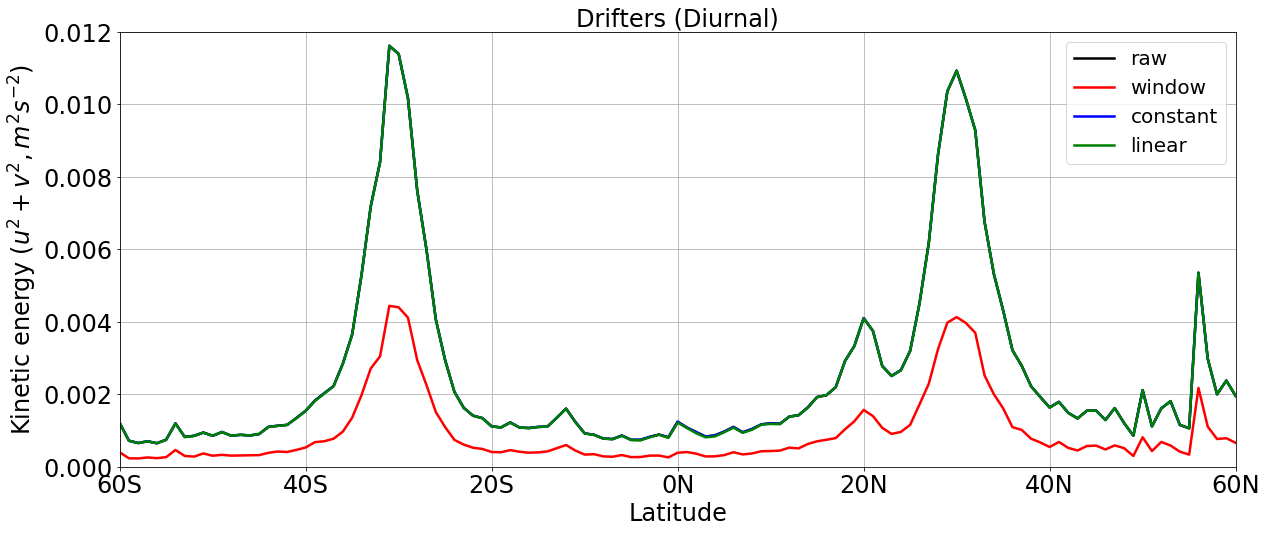

In [30]:
# diurnal 

fig, ax = plt.subplots(figsize=(20,8))

labels = ['raw', 'window','constant', 'linear']

(E_drifter_raw.where((abs(E_drifter_raw.freq_cpd)>0.9) & (abs(E_drifter_raw.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time').plot(color='black', label=labels[0], linewidth=2.5) # energy around semi-diurnal frequencies
(E_drifter_window.where((abs(E_drifter_window.freq_cpd)>0.9) & (abs(E_drifter_window.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time').plot(color='red', label=labels[1], linewidth=2.5) # energy around semi-diurnal frequencies
(E_drifter_constant.where((abs(E_drifter_constant.freq_cpd)>0.9) & (abs(E_drifter_constant.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time').plot(color='blue', label=labels[2], linewidth=2.5) # energy around semi-diurnal frequencies
(E_drifter_linear.where((abs(E_drifter_linear.freq_cpd)>0.9) & (abs(E_drifter_linear.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time').plot(color='green', label=labels[3], linewidth=2.5) # energy around semi-diurnal frequencies

ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.012])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

ax.set_title('Drifters (Diurnal)',fontsize=24)

# compare with u^2 + v^2

In [27]:
# (u,v) --> u+iv
uv = drifter_dataset['uv2'].value.view(np.double).reshape((126303, 1440, 2))
u_drifters = uv[:,:,0] 
v_drifters = uv[:,:,1]

In [28]:
KE_drifters = (u_drifters**2 + v_drifters**2)

In [29]:
# Drifter Dataset (u+iv,lat,qd,time)
ds_KE = xr.Dataset({'KE_drifters': (['lat', 'time'], KE_drifters)},
                 coords={'lat': (['lat'], lat),
                         'time':(['time'], np.arange(1440)*3600),
                         'qd':(['lat'], qd)})
print(ds_KE)

<xarray.Dataset>
Dimensions:      (lat: 126303, time: 1440)
Coordinates:
  * lat          (lat) float64 39.52 39.68 40.44 32.82 33.22 33.98 35.36 ...
  * time         (time) int64 0 3600 7200 10800 14400 18000 21600 25200 ...
    qd           (lat) uint8 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 ...
Data variables:
    KE_drifters  (lat, time) float64 0.1058 0.1037 0.09827 0.05973 0.06012 ...


In [30]:
KE_drifters_mean = ds_KE.KE_drifters.where(ds_KE.qd>0).mean(dim=['time'])
KE_drifters_mean = np.real(KE_drifters_mean).rename('KE_drifters_mean')
KE_drifters_mean

<xarray.DataArray 'KE_drifters_mean' (lat: 126303)>
array([     nan,      nan,      nan, ..., 0.017986, 0.175524, 0.160859])
Coordinates:
  * lat      (lat) float64 39.52 39.68 40.44 32.82 33.22 33.98 35.36 34.89 ...
    qd       (lat) uint8 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 ...

In [31]:
E_uv_zonmean = KE_drifters_mean.groupby_bins(KE_drifters_mean.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat'])
E_KE_drifter = E_uv_zonmean.load()

In [35]:
E_KE_drifter

<xarray.DataArray 'KE_drifters_mean' (lat_bins: 121)>
array([0.067241, 0.088456, 0.104173, 0.121559, 0.130885, 0.110559, 0.112492,
       0.100653, 0.094532, 0.107458, 0.116926, 0.124354, 0.122155, 0.107683,
       0.107975, 0.104709, 0.099218, 0.106018, 0.122054, 0.141296, 0.174564,
       0.19722 , 0.154134, 0.124392, 0.093713, 0.097095, 0.088562, 0.089911,
       0.082803, 0.086427, 0.100735, 0.091134, 0.086815, 0.078468, 0.064238,
       0.068817, 0.062721, 0.051209, 0.046866, 0.045446, 0.041287, 0.046835,
       0.051743, 0.049759, 0.054734, 0.056641, 0.060334, 0.076513, 0.074308,
       0.062812, 0.065333, 0.058464, 0.0687  , 0.085903, 0.116145, 0.13409 ,
       0.160338, 0.198247, 0.222738, 0.24688 , 0.334666, 0.258276, 0.30496 ,
       0.261668, 0.262447, 0.225985, 0.211841, 0.183617, 0.146056, 0.12888 ,
       0.111302, 0.103667, 0.090026, 0.07966 , 0.077798, 0.076093, 0.078035,
       0.087946, 0.089012, 0.089396, 0.088929, 0.088875, 0.070295, 0.064517,
       0.063493, 0.067

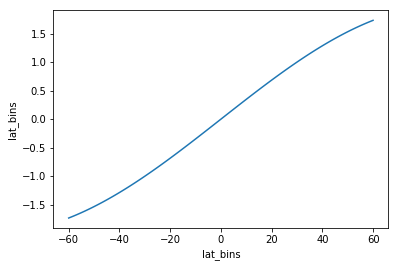

In [36]:
# Inertial frequency
f_drifter = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_KE_drifter.lat_bins))
f_cpd_drifter = f_drifter*86400/2./np.pi
f_cpd_drifter.plot()

Text(0.5,1,'Drifters')

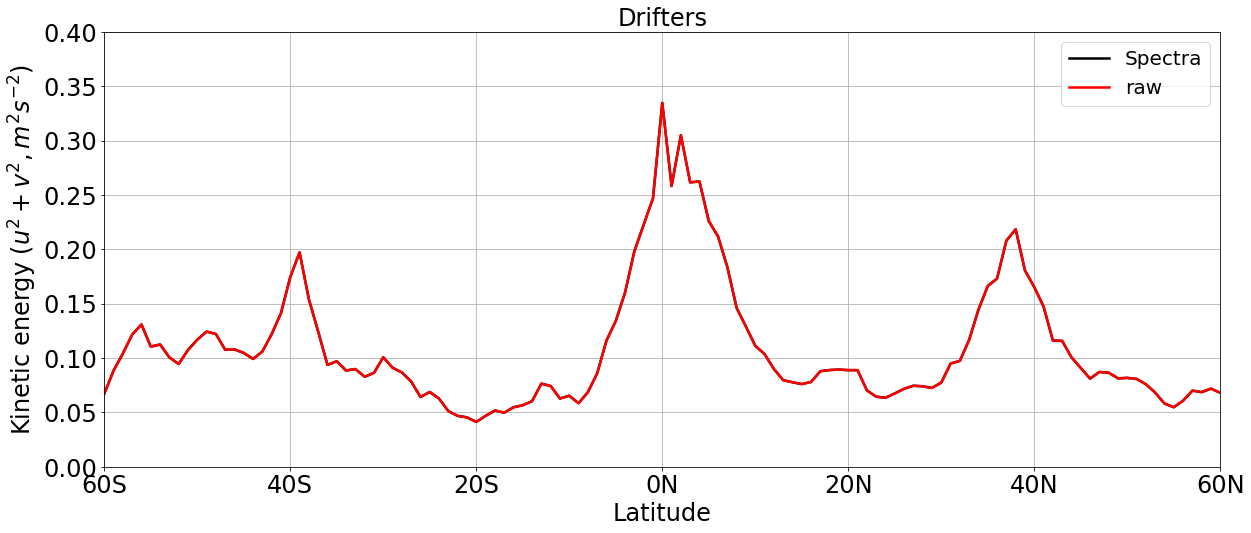

In [32]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['Spectra', 'raw']

(E_drifter_raw*df).sum(dim='freq_time').plot(color='black', label=labels[0], linewidth=2.5) # total energy
(E_KE_drifter).plot(color='red', label=labels[1], linewidth=2.5) # total energy
ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.4])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

ax.set_title('Drifters',fontsize=24)

## global averaged

In [17]:
# cyclonic spectra
E_uv_1 = ((E_uv_blocks).where( (E_uv_blocks.lat>0.) & (E_uv_blocks.freq_time>0.) )).mean(dim=('lat'))   
E_uv_1 = np.real(E_uv_1).rename('E_uv_1')
E_uv_1 

E_uv_2 = ((E_uv_blocks).where( (E_uv_blocks.lat<0.) & (E_uv_blocks.freq_time<0.) )).mean(dim=('lat'))   
E_uv_2 = E_uv_2.assign_coords(freq_time=E_uv_2.freq_time * -1.) 
E_uv_2 = np.real(E_uv_2).rename('E_uv_2')
E_uv_2 

E_drifter_cycl = (E_uv_1 + E_uv_2)/8.64 #(unit:cm^2 s^-2/cpd)
E_drifter_cycl = E_drifter_cycl.assign_coords(freq_time=E_drifter_cycl.freq_time * 86400.) 
E_drifter_cycl

<xarray.DataArray (freq_time: 1439)>
array([        nan, 6909.277951, 4691.691063, ...,         nan,         nan,
               nan])
Coordinates:
  * freq_time          (freq_time) float64 -0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07

In [18]:
# anti-cyclonic spectra
E_uv_3 = ((E_uv_blocks).where( (E_uv_blocks.lat<0.) & (E_uv_blocks.freq_time>0.) )).mean(dim=('lat'))   
E_uv_3 = np.real(E_uv_3).rename('E_uv_3') 

E_uv_4 = ((E_uv_blocks).where( (E_uv_blocks.lat>0.) & (E_uv_blocks.freq_time<0.) )).mean(dim=('lat'))   
E_uv_4 = E_uv_4.assign_coords(freq_time=E_uv_4.freq_time * -1.) 
E_uv_4 = np.real(E_uv_4).rename('E_uv_4')
E_uv_4 

E_drifter_anti = (E_uv_3 + E_uv_4)/8.64 #(unit:cm^2 s^-2/cpd)
E_drifter_anti = E_drifter_anti.assign_coords(freq_time=E_drifter_anti.freq_time * 86400.) 
E_drifter_anti

<xarray.DataArray (freq_time: 1439)>
array([        nan, 7926.209504, 5902.417182, ...,         nan,         nan,
               nan])
Coordinates:
  * freq_time          (freq_time) float64 -0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07

Text(0.5,1,'Drifters')

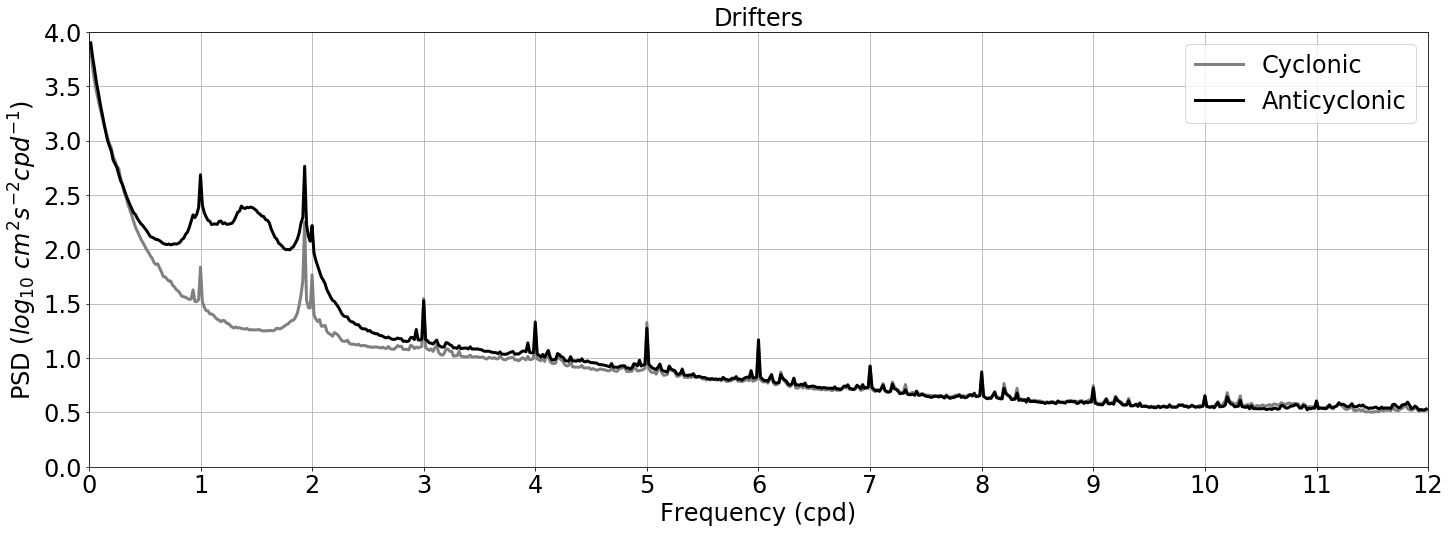

In [19]:
fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic', 'Anticyclonic']

np.log10(E_drifter_cycl).plot(ax=ax, linewidth=3, color='grey', label=labels[0])
np.log10(E_drifter_anti).plot(ax=ax, linewidth=3, color='black', label=labels[1])

ax.legend(); ax.grid()
ax.set_ylim([0.,4])
ax.set_yticks([0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5,4.])
ax.set_xlim([0.,12.])

ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('Drifters',fontsize=24)

#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_globally_averaged.png')

Text(0.5,1,'Drifters')

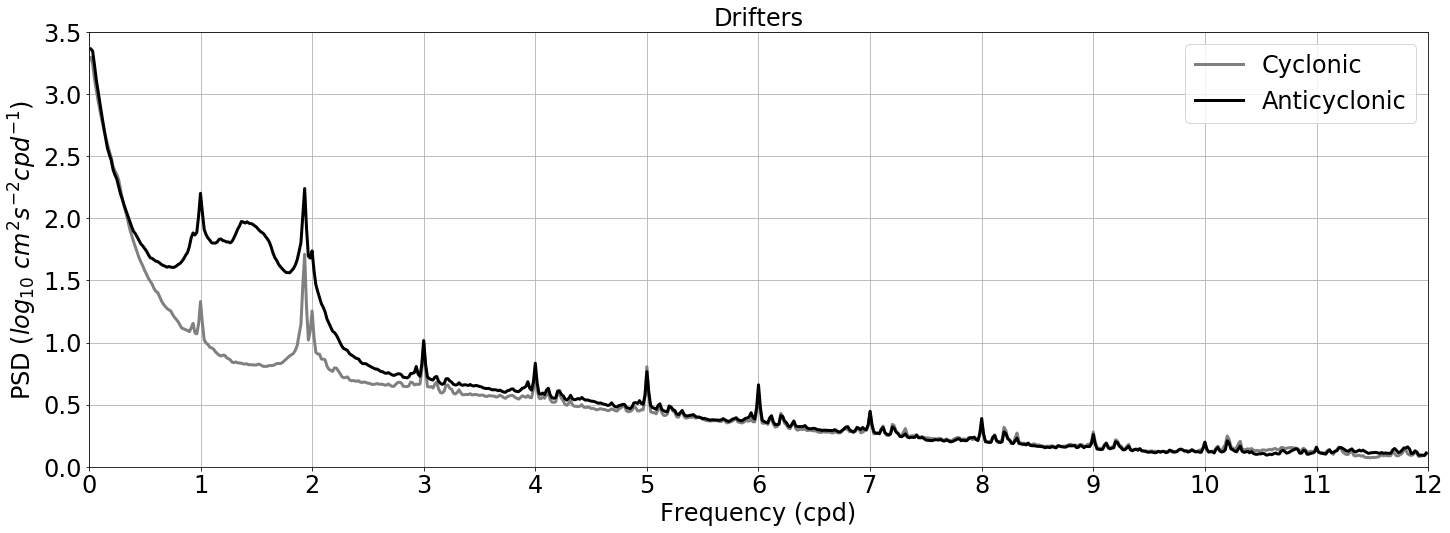

In [18]:
fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic', 'Anticyclonic']

np.log10(E_drifter_cycl).plot(ax=ax, linewidth=3, color='grey', label=labels[0])
np.log10(E_drifter_anti).plot(ax=ax, linewidth=3, color='black', label=labels[1])

ax.legend(); ax.grid()
ax.set_ylim([0.,3.5])
ax.set_yticks([0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5])
ax.set_xlim([0.,12.])

ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('Drifters',fontsize=24)

#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_globally_averaged.png')

__________
# 2. Compare with LLC4320

In [21]:
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
E_dir = '/home1/scratch/xyu/mit_spec/zavg_UV/'

D = [xr.open_zarr(E_dir+'E_rotary_zavg_openocean_f%02d_1080.zarr'%(face)) for face in face_all] # open-ocean
ds = xr.concat(D, dim='face')
print(ds)

<xarray.Dataset>
Dimensions:    (face: 13, freq_time: 1439, lat: 120)
Coordinates:
  * freq_time  (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
Dimensions without coordinates: face
Data variables:
    A          (face, lat) float64 dask.array<shape=(13, 120), chunksize=(1, 120)>
    E          (face, lat, freq_time) float64 dask.array<shape=(13, 120, 1439), chunksize=(1, 60, 720)>


In [27]:
E_llc = (ds.E*ds.A).sum(dim='face') / ds.A.sum(dim='face')
E_llc = E_llc.assign_coords(freq_cpd=E_llc.freq_time * 86400.) 
print(E_llc)

<xarray.DataArray (lat: 120, freq_time: 1439)>
dask.array<shape=(120, 1439), dtype=float64, chunksize=(60, 720)>
Coordinates:
  * freq_time  (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
    freq_cpd   (freq_time) float64 -11.99 -11.98 -11.96 -11.94 -11.93 -11.91 ...


In [28]:
df=E_llc.freq_time[1]-E_llc.freq_time[0]
print(df)

<xarray.DataArray 'freq_time' ()>
array(1.929012e-07)


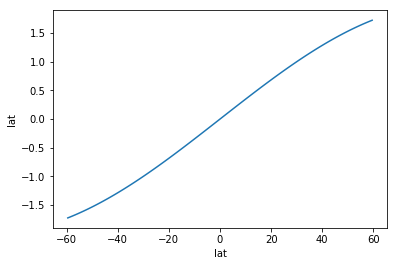

In [29]:
# Inertial frequency
f_llc = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_llc.lat))
f_cpd_llc = f_llc*86400/2./np.pi
f_cpd_llc.plot()

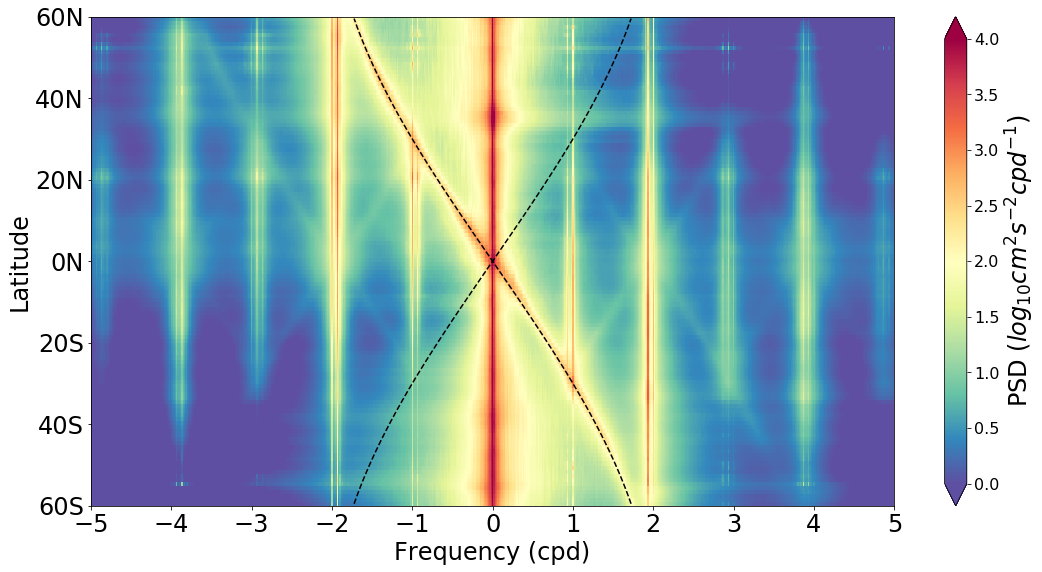

In [34]:
plt.figure(figsize=(18,9))

## LLC4320
ax = plt.subplot(1,1,1)
E_llc = E_llc.assign_coords(freq_cpd=E_llc.freq_time * 86400.) 
cax = np.log10(E_llc/8.64).plot.pcolormesh(ax=ax, vmin=-0.0, vmax=4., x='freq_cpd', y='lat', cmap = 'Spectral_r', add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=24) 
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylabel('Latitude',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
# add coriolis frequency
ax.plot(f_llc*86400./2./np.pi,f_llc.lat,'k--')
ax.plot(-f_llc*86400./2./np.pi,f_llc.lat,'k--')
ax.set_title('',fontsize=24)

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_LLC_1.png')


Text(0.5,1,'Drifters')

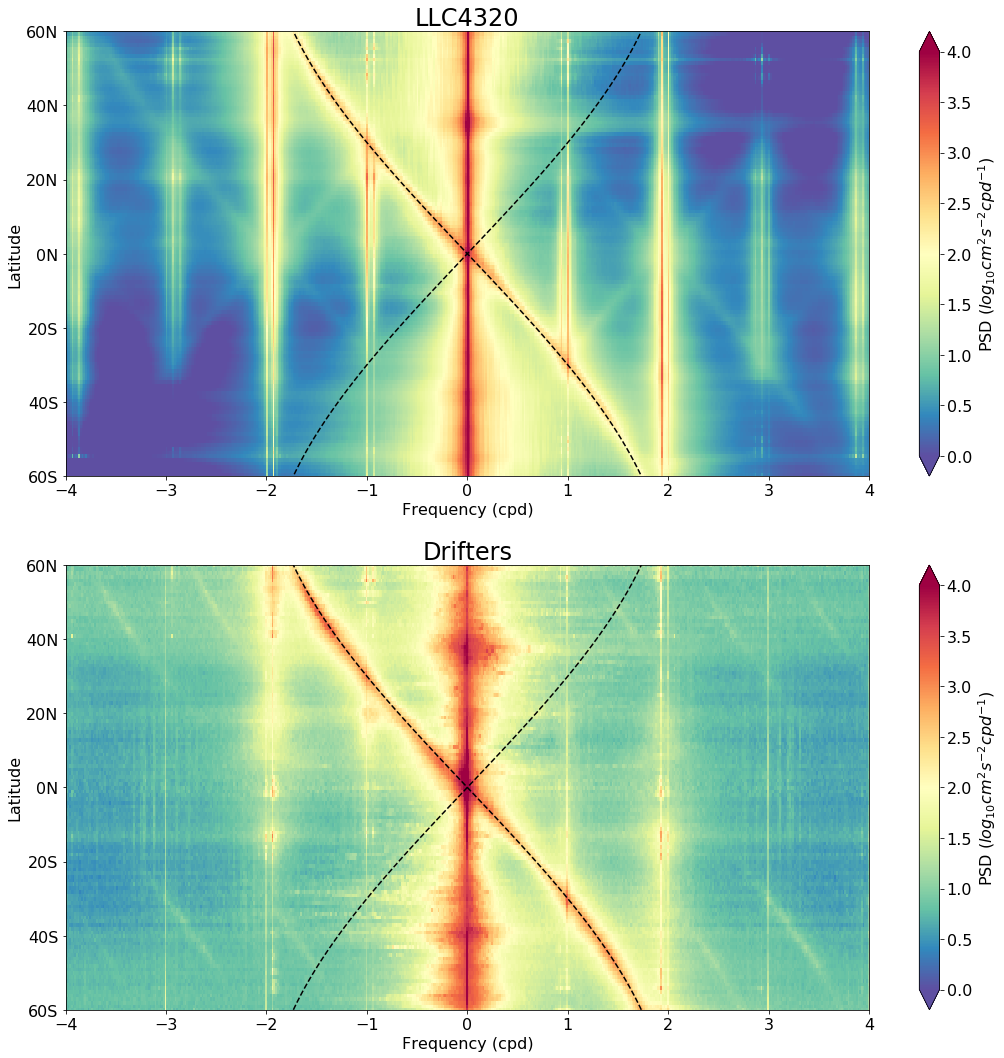

In [52]:
plt.figure(figsize=(18,18))

## LLC4320
ax = plt.subplot(2,1,1)
E_llc = E_llc.assign_coords(freq_cpd=E_llc.freq_time * 86400.) 
cax = np.log10(E_llc/8.64).plot.pcolormesh(ax=ax, vmin=0, vmax=4., x='freq_cpd', y='lat', cmap = 'Spectral_r', add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=16) 
# x,y ticks
#ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-4., 4.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylabel('Latitude',fontsize=16)
ax.set_xlabel('Frequency (cpd)',fontsize=16)
ax.tick_params(labelsize=16)
# add coriolis frequency
ax.plot(f_llc*86400./2./np.pi,f_llc.lat,'k--')
ax.plot(-f_llc*86400./2./np.pi,f_llc.lat,'k--')
ax.set_title('LLC4320',fontsize=24)


## Drifter
ax = plt.subplot(2,1,2)
cax = np.log10(E_drifter.sortby('freq_time')/8.64).plot.pcolormesh(ax=ax, vmin=0, vmax=4., x='freq_cpd', y='lat_bins', cmap = 'Spectral_r', add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=16) 
# x,y ticks
#ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-4., 4.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylabel('Latitude',fontsize=16)
ax.set_xlabel('Frequency (cpd)',fontsize=16)
ax.tick_params(labelsize=16)
# add coriolis frequency
f_drifter = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_drifter.lat_bins))
ax.plot(f_drifter*86400./2./np.pi,f_drifter.lat_bins,'k--')
ax.plot(-f_drifter*86400./2./np.pi,f_drifter.lat_bins,'k--')
ax.set_title('Drifters',fontsize=24)


Text(0.5,1,'Drifters')

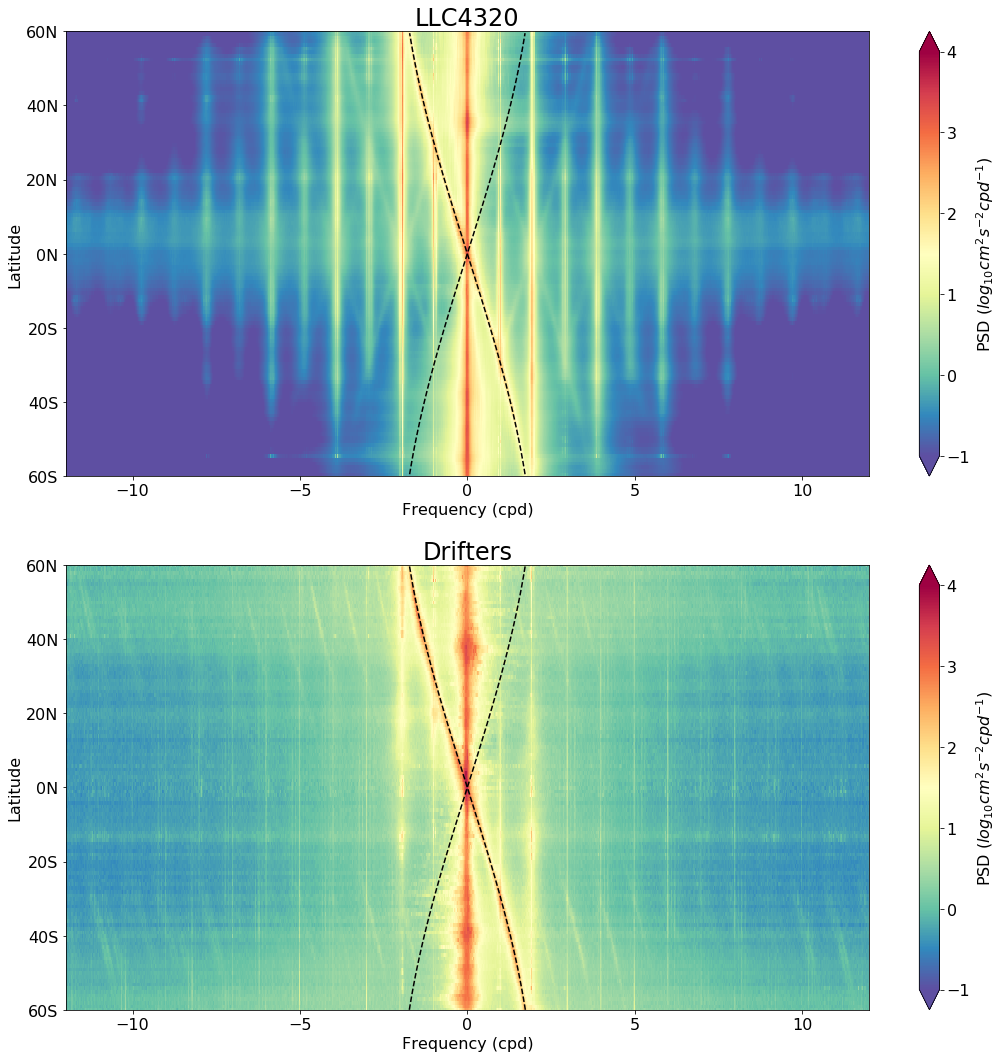

In [26]:
plt.figure(figsize=(18,18))

## LLC4320
ax = plt.subplot(2,1,1)
E_llc = E_llc.assign_coords(freq_cpd=E_llc.freq_time * 86400.) 
cax = np.log10(E_llc/8.64).plot.pcolormesh(ax=ax, vmin=-1, vmax=4., x='freq_cpd', y='lat', cmap = 'Spectral_r', add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=16) 
# x,y ticks
#ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-12., 12.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylabel('Latitude',fontsize=16)
ax.set_xlabel('Frequency (cpd)',fontsize=16)
ax.tick_params(labelsize=16)
# add coriolis frequency
ax.plot(f_llc*86400./2./np.pi,f_llc.lat,'k--')
ax.plot(-f_llc*86400./2./np.pi,f_llc.lat,'k--')
ax.set_title('LLC4320',fontsize=24)


## Drifter
ax = plt.subplot(2,1,2)
cax = np.log10(E_drifter.sortby('freq_time')/8.64).plot.pcolormesh(ax=ax, vmin=-1, vmax=4., x='freq_cpd', y='lat_bins', cmap = 'Spectral_r', add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=16) 
# x,y ticks
#ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-12., 12.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylabel('Latitude',fontsize=16)
ax.set_xlabel('Frequency (cpd)',fontsize=16)
ax.tick_params(labelsize=16)
# add coriolis frequency
f_drifter = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_drifter.lat_bins))
ax.plot(f_drifter*86400./2./np.pi,f_drifter.lat_bins,'k--')
ax.plot(-f_drifter*86400./2./np.pi,f_drifter.lat_bins,'k--')
ax.set_title('Drifters',fontsize=24)


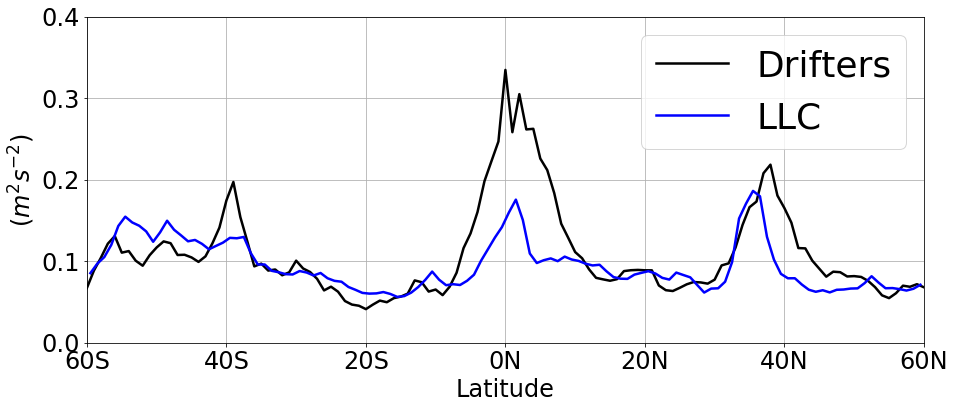

In [40]:
fig= plt.subplots(figsize=(15,6))

labels = ['LLC', 'Drifters']

ax=plt.subplot(111)
(E_drifter*df).sum(dim='freq_time').plot(color='black', label=labels[1], linewidth=2.5) # total energy
(E_llc*df).sum(dim='freq_time').plot(color='blue', label=labels[0], linewidth=2.5) # total energy
ax.legend(prop={'size': 36}); ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.4])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_ylabel('($m^2 s^{-2}$)',fontsize=24)
ax.set_title('',fontsize=24)

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Band_intergal_1.png')


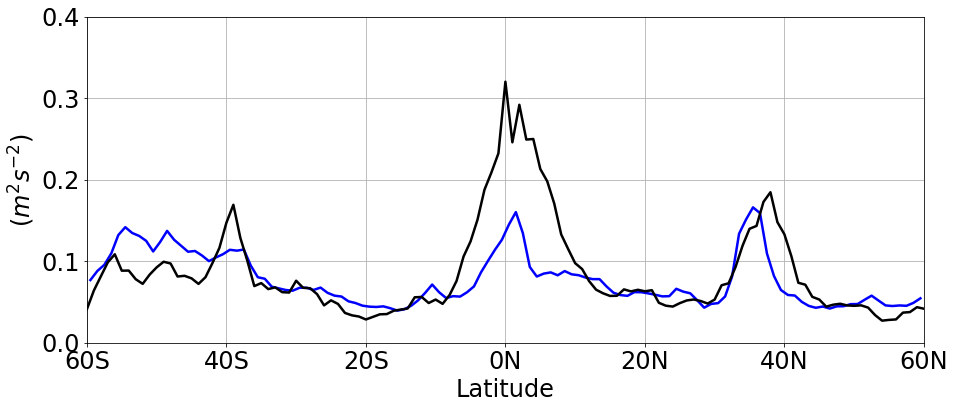

In [41]:
fig= plt.subplots(figsize=(15,6))

labels = ['LLC', 'Drifters']

ax=plt.subplot(111)
(E_llc.where((abs(E_llc.freq_cpd)>=0) & (abs(E_llc.freq_cpd)<0.5), other=0.)*df).sum(dim='freq_time').plot(color='blue', label=labels[0], linewidth=2.5)   # energy at low frequencies (> 5 days) 
(E_drifter.where((abs(E_drifter.freq_cpd)>=0) & (abs(E_drifter.freq_cpd)<0.5), other=0.)*df).sum(dim='freq_time').plot(color='black', label=labels[1], linewidth=2.5)   # energy at low frequencies (> 5 days) 
#ax.legend(prop={'size': 20}); 
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.4])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_ylabel('($m^2 s^{-2}$)',fontsize=24)
ax.set_title('',fontsize=24)

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Band_intergal_2.png')


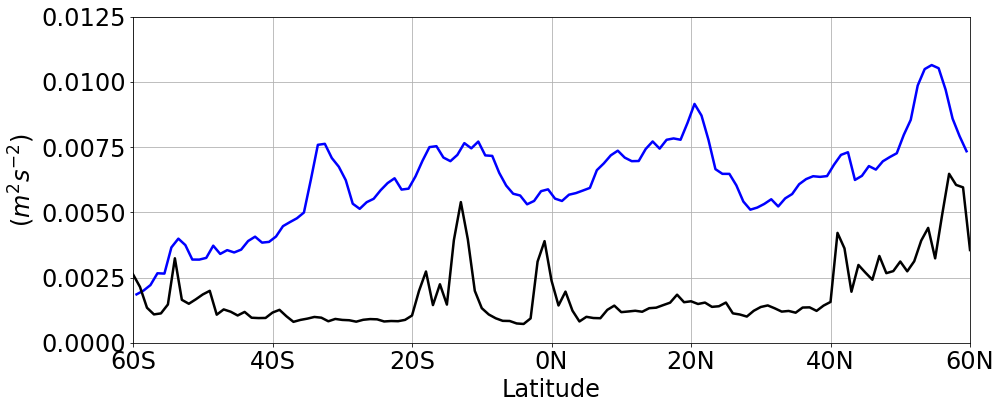

In [46]:
fig= plt.subplots(figsize=(15,6))

labels = ['LLC', 'Drifters']

ax=plt.subplot(111)
(E_llc.where((abs(E_llc.freq_cpd)>1.9) & (abs(E_llc.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time').plot(color='blue', label=labels[0],  linewidth=2.5) # energy around semi-diurnal frequencies
(E_drifter.where((abs(E_drifter.freq_cpd)>1.9) & (abs(E_drifter.freq_cpd)<2.1), other=0.)*df).sum(dim='freq_time').plot(color='black', label=labels[1],  linewidth=2.5) # energy around semi-diurnal frequencies
#ax.legend(prop={'size': 32}); 
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.0125])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_ylabel('($m^2 s^{-2}$)',fontsize=24)
ax.set_title('',fontsize=24)

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Band_intergal_3.png')


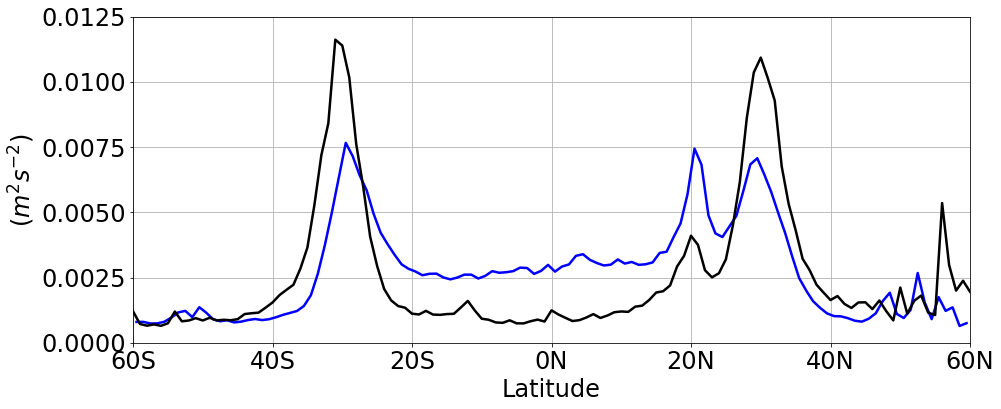

In [47]:
fig= plt.subplots(figsize=(15,6))

ax=plt.subplot(111)
(E_llc.where((abs(E_llc.freq_cpd)>0.9) & (abs(E_llc.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time').plot(color='blue', linewidth=2.5) # energy around diurnal frequencies
(E_drifter.where((abs(E_drifter.freq_cpd)>0.9) & (abs(E_drifter.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time').plot(color='black', linewidth=2.5) # energy around diurnal frequencies
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.0125])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_ylabel('($m^2 s^{-2}$)',fontsize=24)
ax.set_title('',fontsize=24)

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Band_intergal_4.png')


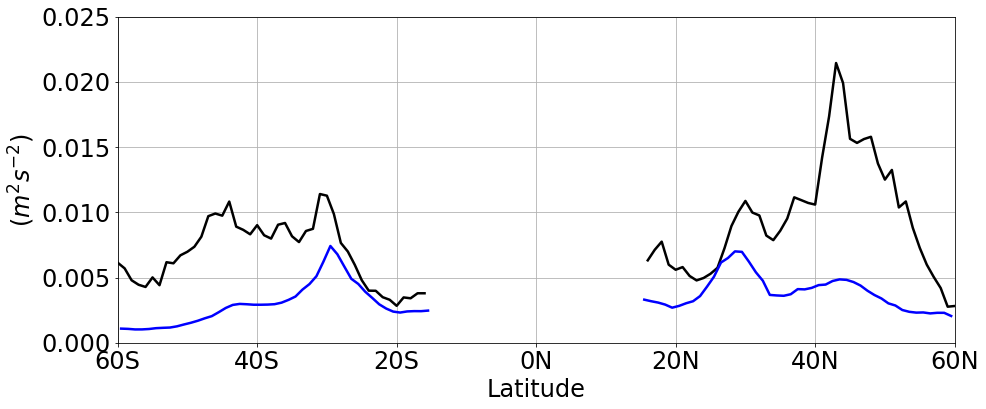

In [49]:
fig= plt.subplots(figsize=(15,6))

labels = ['Drifters', 'LLC']

ax=plt.subplot(111)
(E_drifter.where(abs(E_drifter.freq_cpd+f_cpd_drifter)<.1, other=0.)*df).sum(dim='freq_time').where(abs(E_drifter.lat_bins)>15).plot(color='black', label=labels[0], linewidth=2.5) # energy around f
(E_llc.where(abs(E_llc.freq_cpd+f_cpd_llc)<.1, other=0.)*df).sum(dim='freq_time').where(abs(E_llc.lat)>15).plot(color='blue', label=labels[1], linewidth=2.5) # energy around f

#ax.legend(prop={'size': 36}); 

ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.025])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_ylabel('($m^2 s^{-2}$)',fontsize=24)
ax.set_title('',fontsize=24)

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Band_intergal_5.png')


## global averaged

In [22]:
E_anti_all = xr.open_zarr(E_dir+'E_anti_all_openocean.zarr')
E_cycl_all = xr.open_zarr(E_dir+'E_cycl_all_openocean.zarr')

In [23]:
E_llc_anti = E_anti_all.E_anti_all
E_llc_cycl = E_cycl_all.E_cycl_all

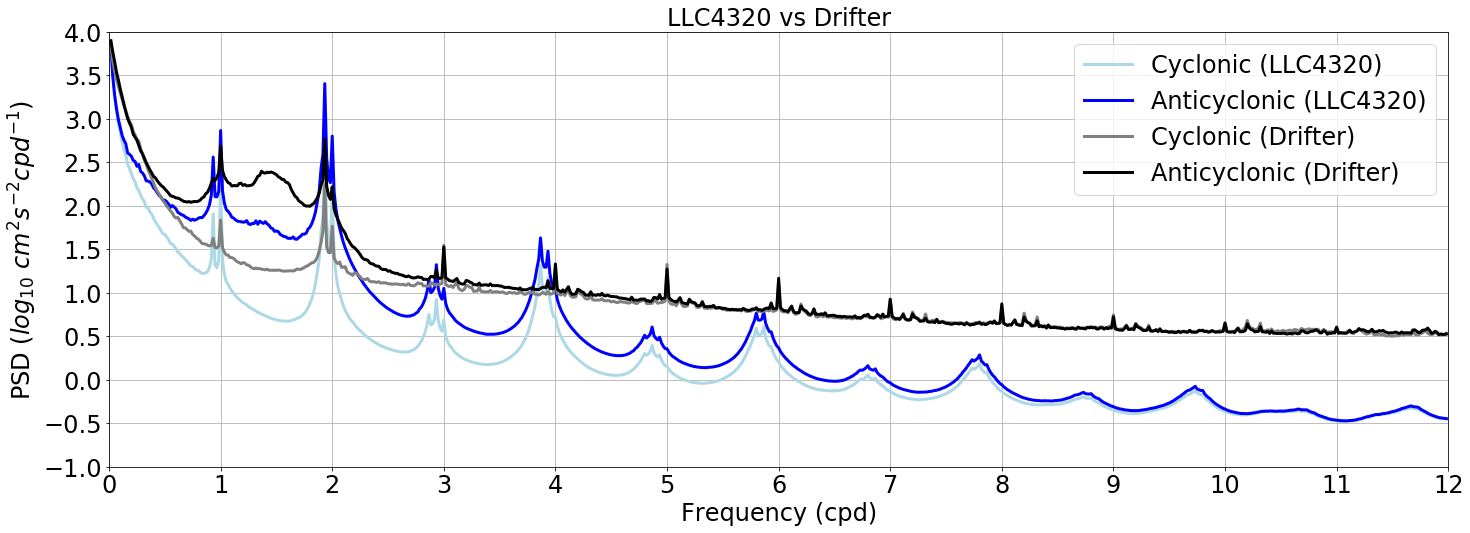

In [25]:

fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic (LLC4320)', 'Anticyclonic (LLC4320)','Cyclonic (Drifter)', 'Anticyclonic (Drifter)']

(np.log10(E_llc_cycl).where(E_cycl_all.freq_time>0)).plot(ax=ax, linewidth=3, color='lightblue', label=labels[0])
(np.log10(E_llc_anti).where(E_anti_all.freq_time>0)).plot(ax=ax, linewidth=3, color='blue', label=labels[1])

np.log10(E_drifter_cycl).plot(ax=ax, linewidth=3, color='grey', label=labels[2])
np.log10(E_drifter_anti).plot(ax=ax, linewidth=3, color='black', label=labels[3])

ax.legend(); ax.grid()
ax.set_ylim([-1.,4])
ax.set_yticks([-1, -0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4.])
ax.set_xlim([0.,12.])
ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('LLC4320 vs Drifter',fontsize=24)

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_globally_averaged.png')

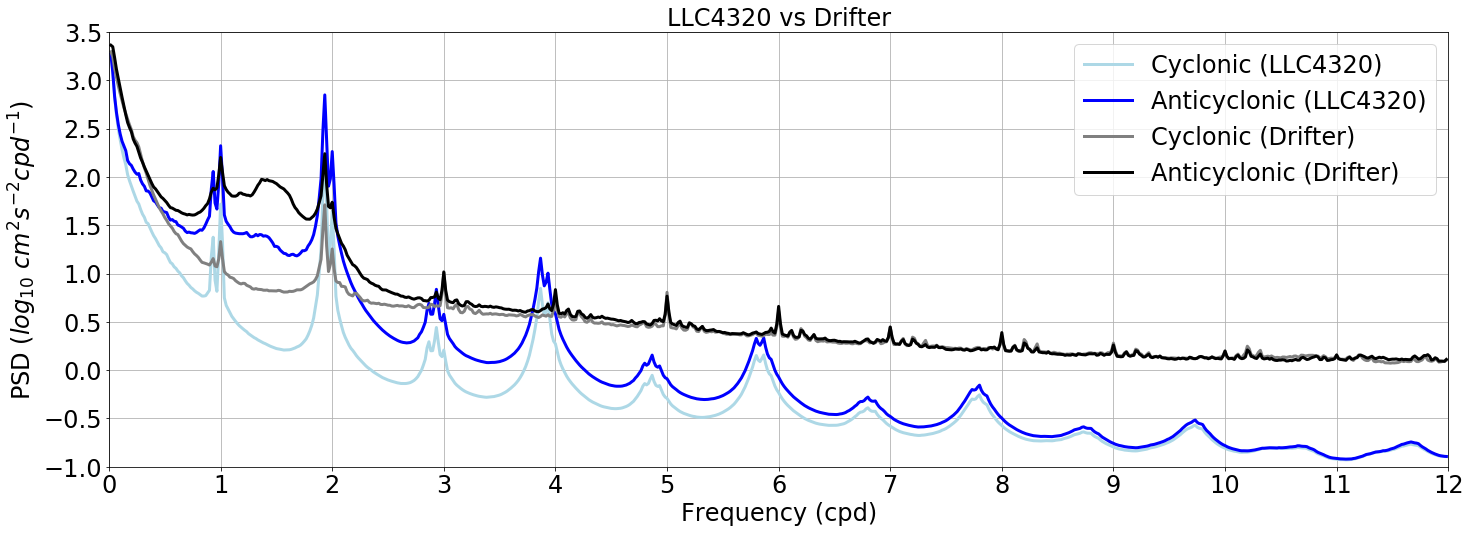

In [59]:

fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic (LLC4320)', 'Anticyclonic (LLC4320)','Cyclonic (Drifter)', 'Anticyclonic (Drifter)']

(np.log10(E_llc_cycl).where(E_cycl_all.freq_time>0)).plot(ax=ax, linewidth=3, color='lightblue', label=labels[0])
(np.log10(E_llc_anti).where(E_anti_all.freq_time>0)).plot(ax=ax, linewidth=3, color='blue', label=labels[1])

np.log10(E_drifter_cycl).plot(ax=ax, linewidth=3, color='grey', label=labels[2])
np.log10(E_drifter_anti).plot(ax=ax, linewidth=3, color='black', label=labels[3])

ax.legend(); ax.grid()
ax.set_ylim([-1.,3.5])
ax.set_yticks([-1, -0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5])
ax.set_xlim([0.,12.])
ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('LLC4320 vs Drifter',fontsize=24)

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_globally_averaged.png')

In [ ]:
cluster.scheduler.close()